## Imports and File Reads

In [70]:
# Standard library imports
import os
import csv
import warnings

# Data processing and numerical operations
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# MIDI processing
import pretty_midi as pm
import mido

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Deep learning frameworks
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Dense, Flatten, Concatenate

import torch as pt

# Progress bar
from tqdm import tqdm

# Configure plotting
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [71]:
root_dir = '../aai-511_group1/midiclassics'

In [73]:
# lets gain some insight about the size of all our files
# also, need to know how many files are in each composers directory

def get_size(start_path):
    total_size = 0
    file_count = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            if f.lower().endswith('.mid') or f.lower().endswith('.midi'):
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
                file_count += 1
    return total_size, file_count

def human_readable_size(size, decimal_places=2):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            break
        size /= 1024.0
    return f"{size:.{decimal_places}f} {unit}"

total_size, file_count = get_size(root_dir)

print(f"Total number of MIDI files: {file_count}")
print(f"Total size of MIDI files: {human_readable_size(total_size)}")

print("\nBreakdown by composer:")
for composer in os.listdir(root_dir):
    composer_dir = os.path.join(root_dir, composer)
    if os.path.isdir(composer_dir):
        composer_size, composer_file_count = get_size(composer_dir)
        print(f"  {composer}: {human_readable_size(composer_size)} ({composer_file_count} files)")

Total number of MIDI files: 1629
Total size of MIDI files: 40.37 MB

Breakdown by composer:
  Bach: 13.13 MB (1022 files)
  Beethoven: 13.92 MB (218 files)
  Chopin: 2.77 MB (134 files)
  Mozart: 10.54 MB (255 files)


In [74]:
# lets gain some insight into what type of MIDI files we are dealing with.
# having different types should not affect the performance of our model, 
# but it is a good idea to know which types we have and the amount so that if we needed to,
# we could take the appropriate amount for testing/training/validation datasets.

def get_midi_type(file_path):
    try:
        midi_file = mido.MidiFile(file_path)
        return midi_file.type
    except:
        return None

def count_midi_types(directory):
    type_counts = {0: 0, 1: 0, 2: 0, 'unknown': 0}
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                file_path = os.path.join(root, file)
                midi_type = get_midi_type(file_path)
                if midi_type is not None and midi_type in type_counts:
                    type_counts[midi_type] += 1
                else:
                    type_counts['unknown'] += 1
    
    return type_counts

type_counts = count_midi_types(root_dir)

print("MIDI File Type Counts:")
for midi_type, count in type_counts.items():
    print(f"  Type {midi_type}: {count}")

MIDI File Type Counts:
  Type 0: 40
  Type 1: 1587
  Type 2: 0
  Type unknown: 2


Type 0 files contain a single track with all MIDI messages merged. They're simple and ideal for straightforward playback but lack flexibility for editing.
- Single track combining all MIDI messages.
- Simple playback.
- Limited editing capabilities.

Type 1 files have multiple tracks, each with its own MIDI channel data. This format is preferred for complex compositions where individual track editing is needed.
- Multiple tracks, each with separate MIDI channels.
- Flexible for editing and arranging.
- Ideal for complex compositions.

Type 2 files contain multiple sequences, each with its own tracks. They're used for organizing and triggering different musical segments independently but are less common.
- Multiple sequences with separate tracks.
- Useful for segment organization.
- Rarely used.

In [75]:
def find_unknown_midi_files(directory):
    unknown_files = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                file_path = os.path.join(root, file)
                try:
                    midi_file = mido.MidiFile(file_path)
                    # If we can open it with mido but couldn't get the type earlier,
                    # it's worth investigating
                    if midi_file.type not in [0, 1, 2]:
                        unknown_files.append(file_path)
                except:
                    unknown_files.append(file_path)
    
    return unknown_files

unknown_files = find_unknown_midi_files(root_dir)

print("Files that couldn't be identified:")
for file in unknown_files:
    print(file)

Files that couldn't be identified:
../aai-511_group1/midiclassics\Beethoven\Anhang 14-3.mid
../aai-511_group1/midiclassics\Mozart\K281 Piano Sonata n03 3mov.mid


Since these files types could not be indentified, I used an online MIDI player to make sure they were not corrupted files and still contained playable music. They are fine, and unsure as to why mido could not identify their type, however this issue should not affect our ability to use these files for our classification task.

### Analysis of single file

In [54]:
def analyze_midi_file(file_path):
    midi_data = pm.PrettyMIDI(file_path)
    
    info = {
        'filename': file_path.split('/')[-1],
        'total_duration': midi_data.get_end_time(),
        'tempo': midi_data.estimate_tempo(),
        'time_signature_changes': len(midi_data.time_signature_changes),
        'key_signature_changes': len(midi_data.key_signature_changes),
        'number_of_instruments': len(midi_data.instruments),
    }
    
    all_notes = []
    all_control_changes = []
    all_pitch_bends = []
    
    for i, instrument in enumerate(midi_data.instruments):
        info[f'instrument_{i}_name'] = instrument.name
        info[f'instrument_{i}_program'] = instrument.program
        info[f'instrument_{i}_is_drum'] = instrument.is_drum
        info[f'instrument_{i}_note_count'] = len(instrument.notes)
        
        for note in instrument.notes:
            all_notes.append({
                'track': i,
                'type': 'note',
                'start': note.start,
                'end': note.end,
                'pitch': note.pitch,
                'velocity': note.velocity
            })
        
        for cc in instrument.control_changes:
            all_control_changes.append({
                'track': i,
                'type': 'control_change',
                'start': cc.time,
                'number': cc.number,
                'value': cc.value
            })
        
        for pb in instrument.pitch_bends:
            all_pitch_bends.append({
                'track': i,
                'type': 'pitch_bend',
                'start': pb.time,
                'value': pb.pitch
            })
    
    # Tempo changes
    tempo_times, tempo_values = midi_data.get_tempo_changes()
    tempo_changes = [{
        'type': 'tempo_change',
        'start': tempo_times[i],
        'tempo': tempo_values[i]
    } for i in range(len(tempo_times))]
    
    return info, all_notes, all_control_changes, all_pitch_bends, tempo_changes

file_path = '../aai-511_group1/midiclassics/Bach/AveMaria.mid'
info, notes, control_changes, pitch_bends, tempo_changes = analyze_midi_file(file_path)


df_info = pd.DataFrame([info])
df_notes = pd.DataFrame(notes)
df_control_changes = pd.DataFrame(control_changes)
df_pitch_bends = pd.DataFrame(pitch_bends)
df_tempo_changes = pd.DataFrame(tempo_changes)

display(df_info.info())
display(df_notes.info())
display(df_control_changes.info())
display(df_pitch_bends.info())
display(df_tempo_changes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1 non-null      object 
 1   total_duration           1 non-null      float64
 2   tempo                    1 non-null      float64
 3   time_signature_changes   1 non-null      int64  
 4   key_signature_changes    1 non-null      int64  
 5   number_of_instruments    1 non-null      int64  
 6   instrument_0_name        1 non-null      object 
 7   instrument_0_program     1 non-null      int32  
 8   instrument_0_is_drum     1 non-null      bool   
 9   instrument_0_note_count  1 non-null      int64  
 10  instrument_1_name        1 non-null      object 
 11  instrument_1_program     1 non-null      int32  
 12  instrument_1_is_drum     1 non-null      bool   
 13  instrument_1_note_count  1 non-null      int64  
 14  instrument_2_name        1 non

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track     793 non-null    int64  
 1   type      793 non-null    object 
 2   start     793 non-null    float64
 3   end       793 non-null    float64
 4   pitch     793 non-null    int64  
 5   velocity  793 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 37.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame


None

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   type    1 non-null      object 
 1   start   1 non-null      float64
 2   tempo   1 non-null      float64
dtypes: float64(2), object(1)
memory usage: 152.0+ bytes


None

In [ ]:
def plot_piano_roll(pm, start_time=0, end_time=None, fs=100):
    """
    Plot a piano roll for the given pretty_midi object.

    Parameters:
    - pm: pretty_midi.PrettyMIDI object
    - start_time: float, start time in seconds
    - end_time: float, end time in seconds
    - fs: int, frame rate of the piano roll (frames per second)
    """
    if end_time is None:
        end_time = pm.get_end_time()
    
    # Get the piano roll (notes)
    piano_roll = pm.get_piano_roll(fs=fs)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the piano roll
    ax.imshow(piano_roll, aspect='auto', origin='lower', 
              extent=[start_time, end_time, 0, 128], cmap='gray_r')
    
    # Set the labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pitch')
    ax.set_title('Piano Roll')
    
    plt.show()


midi_data = pm.PrettyMIDI(file_path)
plot_piano_roll(midi_data)

In [55]:
# def process_midi_directory(root_dir):
#     data = []
#     for composer in os.listdir(root_dir):
#         composer_dir = os.path.join(root_dir, composer)
#         if os.path.isdir(composer_dir):
#             for root, _, files in os.walk(composer_dir):
#                 for file in tqdm(files, desc=f"Processing {composer}"):
#                     if file.lower().endswith(('.mid', '.midi')):
#                         file_path = os.path.join(root, file)
#                         try:
#                             info, notes, control_changes, pitch_bends, tempo_changes = analyze_midi_file(file_path)
#                             info['composer'] = composer
#                             data.append(info)
#                         except Exception as e:
#                             print(f"Error processing {file_path}: {str(e)}")
    
#     return pd.DataFrame(data)


# midi_dataset = process_midi_directory(root_dir)
# midi_dataset.to_csv('midi_dataset.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)

# display(midi_dataset.head())
# display(midi_dataset.shape)

Processing Beethoven:   5%|▍         | 7/141 [00:01<00:14,  9.46it/s]

Error processing ../aai-511_group1/midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Mozart:  24%|██▎       | 9/38 [00:01<00:03,  8.19it/s]

Error processing ../aai-511_group1/midiclassics\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Processing Mozart: 100%|██████████| 20/20 [00:00<00:00, 43.92it/s]


,filename,total_duration,tempo,time_signature_changes,key_signature_changes,number_of_instruments,instrument_0_name,instrument_0_program,instrument_0_is_drum,instrument_0_note_count,...,instrument_37_is_drum,instrument_37_note_count,instrument_38_name,instrument_38_program,instrument_38_is_drum,instrument_38_note_count,instrument_39_name,instrument_39_program,instrument_39_is_drum,instrument_39_note_count
0,midiclassics\Bach\AveMaria.mid,82.000000,240.000000,1,0,3,,0,False,645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,midiclassics\Bach\Bwv0525 Sonate en trio n1.mid,851.974511,185.898927,3,0,3,Track 1,0,False,2419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,midiclassics\Bach\Bwv0526 Sonate en trio n2.mid,760.310995,245.869697,3,0,3,Track 1,19,False,2166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,midiclassics\Bach\Bwv0527 Sonate en trio n3.mid,920.431386,205.919750,3,0,3,Track 1,19,False,2484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,midiclassics\Bach\Bwv0528 Sonate en trio n4.mid,628.280114,169.690991,4,0,3,Track 1,19,False,1655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1628, 167)

In [56]:
def process_midi_directory(root_dir):
    data = []
    all_notes = []
    all_control_changes = []
    all_pitch_bends = []
    all_tempo_changes = []
    
    for composer in os.listdir(root_dir):
        composer_dir = os.path.join(root_dir, composer)
        if os.path.isdir(composer_dir):
            for root, _, files in os.walk(composer_dir):
                for file in tqdm(files, desc=f"Processing {composer}"):
                    if file.lower().endswith(('.mid', '.midi')):
                        file_path = os.path.join(root, file)
                        try:
                            info, notes, control_changes, pitch_bends, tempo_changes = analyze_midi_file(file_path)
                            info['composer'] = composer
                            data.append(info)
                            
                            file_id = len(data) - 1  # Use this as a unique identifier for the file
                            
                            for note in notes:
                                note['file_id'] = file_id
                                all_notes.append(note)
                            
                            for cc in control_changes:
                                cc['file_id'] = file_id
                                all_control_changes.append(cc)
                            
                            for pb in pitch_bends:
                                pb['file_id'] = file_id
                                all_pitch_bends.append(pb)
                            
                            for tc in tempo_changes:
                                tc['file_id'] = file_id
                                all_tempo_changes.append(tc)
                            
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
    
    df_info = pd.DataFrame(data)
    df_notes = pd.DataFrame(all_notes)
    df_control_changes = pd.DataFrame(all_control_changes)
    df_pitch_bends = pd.DataFrame(all_pitch_bends)
    df_tempo_changes = pd.DataFrame(all_tempo_changes)
    
    return df_info, df_notes, df_control_changes, df_pitch_bends, df_tempo_changes


df_info, df_notes, df_control_changes, df_pitch_bends, df_tempo_changes = process_midi_directory(root_dir)

df_info.to_csv('midi_info.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)
df_notes.to_csv('midi_notes.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)
df_control_changes.to_csv('midi_control_changes.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)
df_pitch_bends.to_csv('midi_pitch_bends.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)
df_tempo_changes.to_csv('midi_tempo_changes.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)

display(df_info.head())
display(df_info.shape)

Processing Beethoven:   5%|▍         | 7/141 [00:00<00:12, 10.73it/s]

Error processing ../aai-511_group1/midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Mozart:  24%|██▎       | 9/38 [00:01<00:04,  6.80it/s]

Error processing ../aai-511_group1/midiclassics\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Processing Mozart: 100%|██████████| 20/20 [00:00<00:00, 51.83it/s]


,filename,total_duration,tempo,time_signature_changes,key_signature_changes,number_of_instruments,instrument_0_name,instrument_0_program,instrument_0_is_drum,instrument_0_note_count,...,instrument_37_is_drum,instrument_37_note_count,instrument_38_name,instrument_38_program,instrument_38_is_drum,instrument_38_note_count,instrument_39_name,instrument_39_program,instrument_39_is_drum,instrument_39_note_count
0,midiclassics\Bach\AveMaria.mid,82.000000,240.000000,1,0,3,,0,False,645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,midiclassics\Bach\Bwv0525 Sonate en trio n1.mid,851.974511,185.898927,3,0,3,Track 1,0,False,2419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,midiclassics\Bach\Bwv0526 Sonate en trio n2.mid,760.310995,245.869697,3,0,3,Track 1,19,False,2166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,midiclassics\Bach\Bwv0527 Sonate en trio n3.mid,920.431386,205.919750,3,0,3,Track 1,19,False,2484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,midiclassics\Bach\Bwv0528 Sonate en trio n4.mid,628.280114,169.690991,4,0,3,Track 1,19,False,1655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1628, 167)

In [58]:
# Add file_id to df_info
df_info['file_id'] = df_info.index

# Group notes by file_id and create features
note_features = df_notes.groupby('file_id').agg({
    'pitch': ['mean', 'std', 'min', 'max'],
    'velocity': ['mean', 'std', 'min', 'max'],
    'start': ['min', 'max'],
    'end': ['max']
}).reset_index()
note_features.columns = ['file_id'] + [f'note_{col[0]}_{col[1]}' for col in note_features.columns[1:]]

# Create features from control changes
cc_features = df_control_changes.groupby('file_id').agg({
    'number': ['nunique'],
    'value': ['mean', 'std']
}).reset_index()
cc_features.columns = ['file_id'] + [f'cc_{col[0]}_{col[1]}' for col in cc_features.columns[1:]]

# Create features from pitch bends
pb_features = df_pitch_bends.groupby('file_id').agg({
    'value': ['mean', 'std', 'min', 'max']
}).reset_index()
pb_features.columns = ['file_id'] + [f'pb_{col[0]}_{col[1]}' for col in pb_features.columns[1:]]

# Create features from tempo changes
tempo_features = df_tempo_changes.groupby('file_id').agg({
    'tempo': ['mean', 'std', 'min', 'max', 'count']
}).reset_index()
tempo_features.columns = ['file_id'] + [f'tempo_{col[0]}_{col[1]}' for col in tempo_features.columns[1:]]

# Merge all features
combined_features = df_info.merge(note_features, on='file_id', how='left')\
                           .merge(cc_features, on='file_id', how='left')\
                           .merge(pb_features, on='file_id', how='left')\
                           .merge(tempo_features, on='file_id', how='left')

# Fill NaN values (in case some files don't have certain features)
combined_features = combined_features.fillna(0)

print(combined_features.head())
print(combined_features.shape)

# Save the combined_features DataFrame to a CSV file
combined_features.to_csv('combined_features.csv', index=False, escapechar='\\', quoting=csv.QUOTE_ALL)

# Print confirmation
print("DataFrame saved to 'combined_features.csv'")

                                          filename  total_duration  \
0                   midiclassics\Bach\AveMaria.mid       82.000000   
1  midiclassics\Bach\Bwv0525 Sonate en trio n1.mid      851.974511   
2  midiclassics\Bach\Bwv0526 Sonate en trio n2.mid      760.310995   
3  midiclassics\Bach\Bwv0527 Sonate en trio n3.mid      920.431386   
4  midiclassics\Bach\Bwv0528 Sonate en trio n4.mid      628.280114   

        tempo  time_signature_changes  key_signature_changes  \
0  240.000000                       1                      0   
1  185.898927                       3                      0   
2  245.869697                       3                      0   
3  205.919750                       3                      0   
4  169.690991                       4                      0   

   number_of_instruments instrument_0_name  instrument_0_program  \
0                      3                                       0   
1                      3           Track 1                

In [59]:
def create_sequence(file_id, max_length=500):
    file_notes = df_notes[df_notes['file_id'] == file_id].sort_values('start')
    sequence = file_notes[['pitch', 'velocity', 'start', 'end']].values
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        padding = np.zeros((max_length - len(sequence), 4))
        sequence = np.vstack((sequence, padding))
    return sequence

# Create sequences for each file
X_lstm = np.array([create_sequence(file_id) for file_id in combined_features['file_id']])
y = combined_features['composer'].values

In [60]:
def create_piano_roll(file_id, time_steps=500, pitch_range=128):
    file_notes = df_notes[df_notes['file_id'] == file_id]
    piano_roll = np.zeros((time_steps, pitch_range))
    for _, note in file_notes.iterrows():
        start = int(note['start'] * time_steps / file_notes['end'].max())
        end = int(note['end'] * time_steps / file_notes['end'].max())
        pitch = int(note['pitch'])
        piano_roll[start:end, pitch] = note['velocity']
    return piano_roll

# Create piano rolls for each file
X_cnn = np.array([create_piano_roll(file_id) for file_id in combined_features['file_id']])

In [61]:
# Normalize LSTM input
scaler_lstm = StandardScaler()
X_lstm_scaled = scaler_lstm.fit_transform(X_lstm.reshape(-1, X_lstm.shape[-1])).reshape(X_lstm.shape)

# Normalize CNN input (assuming X_cnn is already created)
scaler_cnn = StandardScaler()
X_cnn_scaled = scaler_cnn.fit_transform(X_cnn.reshape(-1, X_cnn.shape[-1])).reshape(X_cnn.shape)

# Normalize combined features
X_combined = combined_features.select_dtypes(include=[np.number])
scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined)

In [62]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("X_lstm_scaled shape:", X_lstm_scaled.shape)
print("X_cnn_scaled shape:", X_cnn_scaled.shape)
print("X_combined_scaled shape:", X_combined_scaled.shape)
print("y_encoded shape:", y_encoded.shape)

X_lstm_scaled shape: (1628, 500, 4)
X_cnn_scaled shape: (1628, 500, 128)
X_combined_scaled shape: (1628, 109)
y_encoded shape: (1628,)


In [63]:
X_lstm_train, X_lstm_test, X_cnn_train, X_cnn_test, X_combined_train, X_combined_test, y_train, y_test = train_test_split(
    X_lstm_scaled, X_cnn_scaled, X_combined_scaled, y_encoded, test_size=0.2, random_state=42
)

print("After splitting:")
print("X_lstm_train shape:", X_lstm_train.shape)
print("X_cnn_train shape:", X_cnn_train.shape)
print("X_combined_train shape:", X_combined_train.shape)
print("y_train shape:", y_train.shape)


After splitting:
X_lstm_train shape: (1302, 500, 4)
X_cnn_train shape: (1302, 500, 128)
X_combined_train shape: (1302, 109)
y_train shape: (1302,)


In [64]:
# LSTM input
lstm_input = Input(shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]))
lstm_out = LSTM(64)(lstm_input)

# CNN input
cnn_input = Input(shape=(X_cnn_train.shape[1], X_cnn_train.shape[2], 1))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(cnn_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
flatten = Flatten()(pool1)

# Combined features input
combined_input = Input(shape=(X_combined_train.shape[1],))

# Merge all features
merged = Concatenate()([lstm_out, flatten, combined_input])

# Output layer
output = Dense(len(np.unique(y)), activation='softmax')(merged)

# Create model
model = Model(inputs=[lstm_input, cnn_input, combined_input], outputs=output)

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(
    [X_lstm_train, X_cnn_train, X_combined_train], 
    y_train, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=32
)

Epoch 1/50
33/33 [==============================] - 17s 459ms/step - loss: 6.1133 - accuracy: 0.6609 - val_loss: 1.7732 - val_accuracy: 0.7854
Epoch 2/50
33/33 [==============================] - 15s 455ms/step - loss: 0.6012 - accuracy: 0.9001 - val_loss: 1.9173 - val_accuracy: 0.7778
Epoch 3/50
33/33 [==============================] - 15s 453ms/step - loss: 0.0823 - accuracy: 0.9750 - val_loss: 1.4362 - val_accuracy: 0.7893
Epoch 4/50
33/33 [==============================] - 15s 457ms/step - loss: 0.0121 - accuracy: 0.9971 - val_loss: 1.5389 - val_accuracy: 0.7969
Epoch 5/50
33/33 [==============================] - 15s 442ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.4073 - val_accuracy: 0.8084
Epoch 6/50
33/33 [==============================] - 15s 447ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.4147 - val_accuracy: 0.8084
Epoch 7/50
33/33 [==============================] - 15s 448ms/step - loss: 8.5434e-04 - accuracy: 1.0000 - val_loss: 1.4326 - val_accuracy: 0.

11/11 [==============================] - 1s 118ms/step - loss: 2.1571 - accuracy: 0.8098
Test Loss: 2.1571
Test Accuracy: 0.8098
11/11 [==============================] - 2s 116ms/step


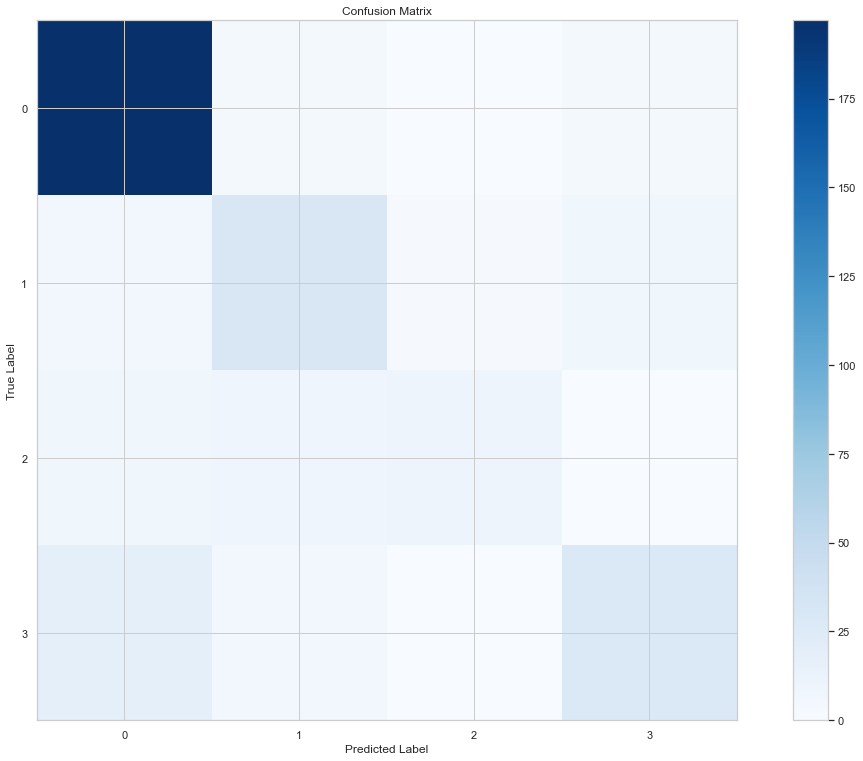

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       205
           1       0.61      0.68      0.65        44
           2       0.83      0.38      0.53        26
           3       0.71      0.53      0.61        51

    accuracy                           0.81       326
   macro avg       0.76      0.64      0.67       326
weighted avg       0.81      0.81      0.80       326



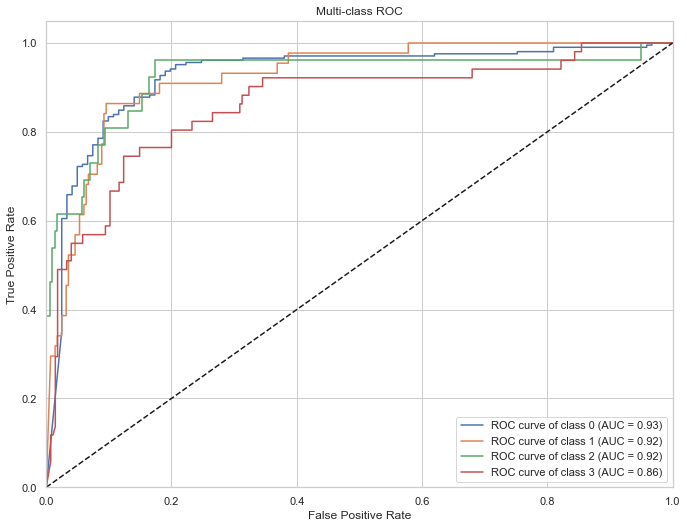

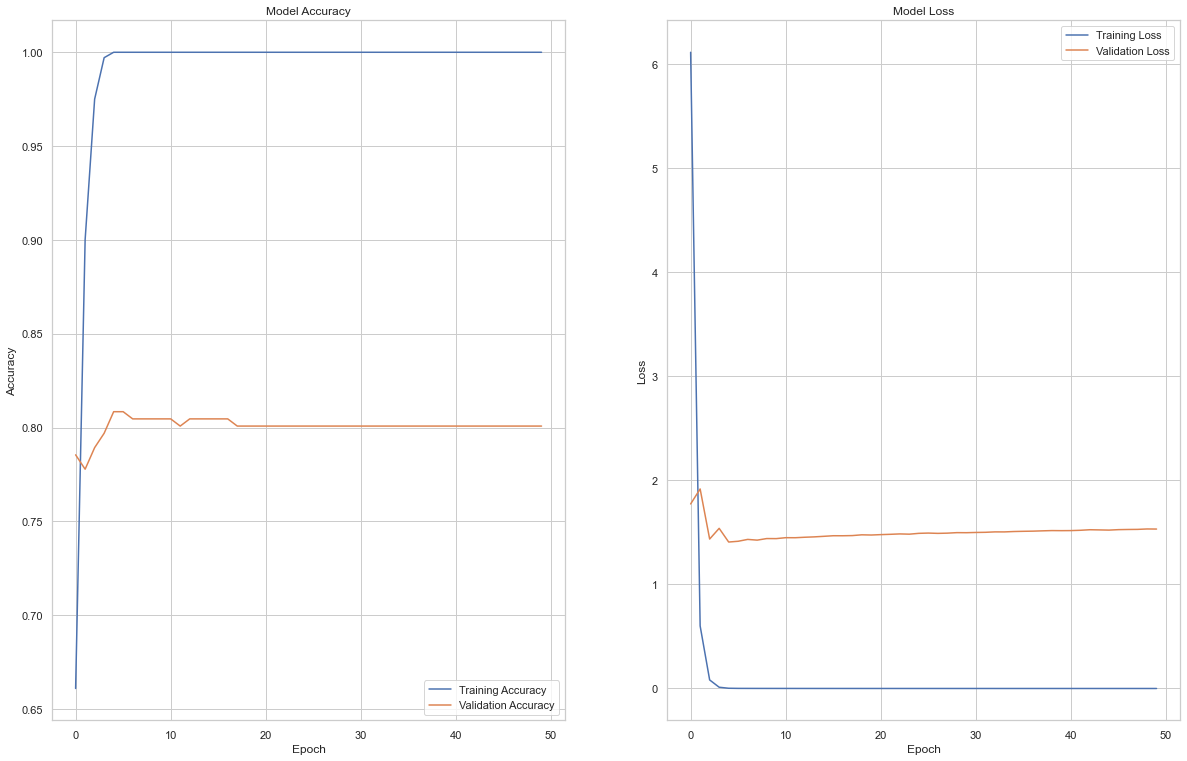

In [65]:
# 1. Model Evaluation
test_loss, test_accuracy = model.evaluate([X_lstm_test, X_cnn_test, X_combined_test], y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred = model.predict([X_lstm_test, X_cnn_test, X_combined_test])
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(18, 12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Classification Report
print(classification_report(y_test, y_pred_classes))

# 4. ROC Curve and AUC (for binary classification)
# If binary classification
if len(np.unique(y_test)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    # For multi-class, you might want to use one-vs-rest ROC curves
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

# 5. Learning Curves
plt.figure(figsize=(18, 12))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Alternative Approach

In [68]:
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

def midi_to_dataframe(midi_path):
    try:
        # Read the MIDI file
        midi = pm.PrettyMIDI(midi_path)
        data = []
        
        # Collect notes, control changes, and pitch bends
        for i, instrument in enumerate(midi.instruments):
            for note in instrument.notes:
                data.append([i, 'note', note.start, note.end, note.pitch, note.velocity])
            for control_change in instrument.control_changes:
                data.append([i, 'control_change', control_change.time, control_change.number, control_change.value])
            for pitch_bend in instrument.pitch_bends:
                data.append([i, 'pitch_bend', pitch_bend.time, pitch_bend.pitch])
        
        # Collect tempo changes from the first track only
        if i == 0:
            for tempo_change in midi.get_tempo_changes():
                data.append([0, 'tempo_change', tempo_change[0], tempo_change[1]])
        
        # Create a dataframe from the data
        df = pd.DataFrame(data, columns=['track', 'type', 'start', 'end', 'pitch_or_number', 'velocity_or_value'])
        return df
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return pd.DataFrame()

composer_dataframes = {}

for composer in composers:
    folder_path = os.path.join(root_dir, composer)
    if os.path.exists(folder_path):
        all_midi_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.mid')]
        composer_dfs = [midi_to_dataframe(midi_file) for midi_file in all_midi_files]
        # Filter out empty dataframes resulting from errors
        composer_dfs = [df for df in composer_dfs if not df.empty]
        if composer_dfs:
            composer_dataframes[composer] = pd.concat(composer_dfs, ignore_index=True)

# getting each composer's dataframe
bach_df = composer_dataframes.get('Bach', pd.DataFrame())
beethoven_df = composer_dataframes.get('Beethoven', pd.DataFrame())
chopin_df = composer_dataframes.get('Chopin', pd.DataFrame())
mozart_df = composer_dataframes.get('Mozart', pd.DataFrame())


Error processing ../aai-511_group1/midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing ../aai-511_group1/midiclassics\Beethoven\Op.51.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Op33 No.4.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Piano Sonata No.27.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Piano Sonatina No.2 Op 49.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Rage over a lost pennny.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Sonata Presto.mid: index 1 is out of bounds for axis 0 with size 1
Error processing ../aai-511_group1/midiclassics\Beethoven\Sonatina In C.mid: index 1 is out of bounds for axis 0 

In [69]:
display(bach_df.info())
display(bach_df.describe())
display(bach_df.head())

display(beethoven_df.info())
display(beethoven_df.describe())
display(beethoven_df.head())

display(chopin_df.info())
display(chopin_df.describe())
display(chopin_df.head())

display(mozart_df.info())
display(mozart_df.describe())
display(mozart_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350047 entries, 0 to 350046
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   track              350047 non-null  int64  
 1   type               350047 non-null  object 
 2   start              350047 non-null  float64
 3   end                350047 non-null  float64
 4   pitch_or_number    349905 non-null  float64
 5   velocity_or_value  339640 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 16.0+ MB


None

,track,start,end,pitch_or_number,velocity_or_value
count,350047.000000,350047.000000,350047.000000,349905.000000,339640.000000
mean,2.027425,285.956503,283.704167,64.633066,95.638756
std,3.963640,256.030106,264.375438,12.306423,17.938681
min,0.000000,0.000000,-482.000000,0.000000,1.000000
25%,0.000000,76.602196,74.700000,57.000000,92.000000
50%,1.000000,195.633973,192.249923,66.000000,92.000000
75%,2.000000,441.123399,437.573605,73.000000,102.000000
max,36.000000,1178.919324,8191.000000,127.000000,127.000000


,track,type,start,end,pitch_or_number,velocity_or_value
0,0,note,0.000,0.125,53.0,30.0
1,0,note,0.125,0.250,57.0,30.0
2,0,note,0.250,0.375,60.0,30.0
3,0,note,0.375,0.500,65.0,30.0
4,0,note,0.500,0.625,69.0,30.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939153 entries, 0 to 939152
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   track              939153 non-null  int64  
 1   type               939153 non-null  object 
 2   start              939153 non-null  float64
 3   end                939153 non-null  float64
 4   pitch_or_number    938908 non-null  float64
 5   velocity_or_value  653575 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 43.0+ MB


None

,track,start,end,pitch_or_number,velocity_or_value
count,939153.000000,939153.000000,939153.000000,938908.000000,653575.000000
mean,7.000168,373.231623,244.053679,67.916392,82.194717
std,6.640570,283.330353,269.086578,19.763285,26.818717
min,0.000000,0.000000,-400.000000,0.000000,1.000000
25%,1.000000,147.419728,11.000000,55.000000,60.000000
50%,6.000000,312.684953,155.353496,67.000000,84.000000
75%,11.000000,533.995873,391.671338,79.000000,103.000000
max,28.000000,1318.203781,1318.203781,127.000000,127.000000


,track,type,start,end,pitch_or_number,velocity_or_value
0,0,note,2.205882,3.447289,72.0,66.0
1,0,note,3.433244,3.545604,75.0,66.0
2,0,note,3.601784,3.829725,74.0,66.0
3,0,note,4.307666,5.392002,67.0,66.0
4,0,note,5.392002,5.476272,67.0,64.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384568 entries, 0 to 384567
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   track              384568 non-null  int64  
 1   type               384568 non-null  object 
 2   start              384568 non-null  float64
 3   end                384568 non-null  float64
 4   pitch_or_number    384455 non-null  float64
 5   velocity_or_value  300162 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 17.6+ MB


None

,track,start,end,pitch_or_number,velocity_or_value
count,384568.000000,384568.000000,384568.000000,384455.000000,300162.000000
mean,1.749667,215.400041,169.154046,64.712955,68.409549
std,3.866665,230.976138,205.354089,23.802041,25.038781
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,56.042304,45.166012,54.000000,49.000000
50%,0.000000,135.689313,84.965221,64.000000,65.000000
75%,1.000000,294.523690,228.827831,75.000000,86.000000
max,19.000000,1352.454167,1352.741667,127.000000,127.000000


,track,type,start,end,pitch_or_number,velocity_or_value
0,0,note,0.000000,0.249908,70.0,105.0
1,0,note,0.000000,0.249908,63.0,105.0
2,0,note,0.312385,0.395687,70.0,105.0
3,0,note,0.312385,0.395687,63.0,105.0
4,0,note,0.416513,0.583118,70.0,105.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386935 entries, 0 to 386934
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   track              386935 non-null  int64  
 1   type               386935 non-null  object 
 2   start              386935 non-null  float64
 3   end                386935 non-null  float64
 4   pitch_or_number    386885 non-null  float64
 5   velocity_or_value  343864 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 17.7+ MB


None

,track,start,end,pitch_or_number,velocity_or_value
count,386935.000000,386935.000000,386935.000000,386885.000000,343864.000000
mean,4.018781,182.802379,169.881821,65.911723,79.609782
std,3.915127,144.733810,151.348301,16.300038,21.172462
min,0.000000,0.000000,-250.000000,0.000000,1.000000
25%,1.000000,72.230697,50.298412,57.000000,64.000000
50%,3.000000,150.300000,132.466233,66.000000,80.000000
75%,7.000000,257.603421,253.838483,74.000000,96.000000
max,18.000000,895.396477,896.521477,127.000000,127.000000


,track,type,start,end,pitch_or_number,velocity_or_value
0,0,note,0.96,1.176,67.0,64.0
1,0,note,1.44,1.824,72.0,64.0
2,0,note,1.92,2.112,72.0,64.0
3,0,note,2.16,2.352,71.0,64.0
4,0,note,2.40,2.616,72.0,64.0


#### References
1. https://machinelearningmastery.com/cnn-long-short-term-memory-networks/
2. https://colinraffel.com/publications/ismir2014intuitive.pdf